# 引言

分析Lending Club风险策略。

https://www.kaggle.com/wendykan/lending-club-loan-data


# 0. 基本设置

In [1]:
import numpy as np
import pandas as pd
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# 设置小数显示2位数
pd.set_option('display.precision', 2) 
# 绘图风格设置
# % matplotlib inline
plt.style.use('ggplot')
# plt.style.use('dark_background') # presentation

In [3]:
# Load data for analysis
df = pd.read_csv('../00_data/lc/loan.csv', low_memory=False)

In [4]:
# Replace the name of some columns
df = df.rename(columns={"loan_amnt": "loan_amount",
                        "funded_amnt": "funded_amount", 
                        "funded_amnt_inv": "investor_funds",
                        "int_rate": "interest_rate", 
                        "annual_inc": "annual_income"})

In [5]:
df.head(2)

,id,member_id,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# df.info()

# 1. 观点与建议

**关键结论**：

1. LC的P2P贷款业务发展迅速，从2007到2015年年均增长率超过100%，2015年的贷款总量超过60亿美元；
用户的单笔贷款金额逐年增加，贷款金额主要集中在5000-20000美元的区间；
2. 贷款的额度大、分期数多（36期、60期）、贷款频率低，主要用途是**集合债务、换信用卡**，用于消费场景的比例较小。贷款利率主要由用户的信用分和分期数决定，利率集中在10%到20%的区间。
3. LC平台的风控能力较差，在2007-2015年之间，贷款的坏账率高达17%，实际收回还款总额是贷款本金的108%，收益率并不高。
4. 风险因素中，违约率随着贷款信用水平下降而单调增加，可见美国的FICO信用评分就能较准确地评估违约风险。

**业务提升建议**：

1. LC平台的贷款利率已经较高，提升业务的关键是加强风控，减少坏账率，并吸引更多优质客户。
2. 信用水平最低的F、G级别贷款违约风险高、总量少，且还款的回报率显著低于级别贷款，建议停止发放此类贷款；
3. 高收入群体的违约率低、贷款金额大，是LC平台的优质客户群。
建议主动吸引更多**高收入用户**以LC作为贷款融资渠道，通过提升客户质量来降低贷款不良风险
4. 发放的贷款的主要分布在B/C/D等级，通过机器学习模型，寻找信用分之外的违约因素，**控制主要客户群的违约风险**水平；
5. LC当前的分期模式只支持36期和60期，建议设置12/24月分期的贷款产品，满足更多**短期、高频的消费贷款**需求，提升用户复用率，扩大业务量；

# 2. 贷款业务整体分析

## 2.1 业务总量分析

贷款笔数和贷款总量均逐年快速增加，2015年发放贷款总额超过60亿美元，超过40万笔。

In [7]:
# 创建年份的变量
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year

In [8]:
year_loan_stat = df.groupby('year')['loan_amount'].agg([sum, 'mean', 'count'], axis='column')
year_loan_stat['sum'] = year_loan_stat['sum'] / 1e6
year_loan_stat['count'] = year_loan_stat['count'] / 1e3

In [9]:
print('从2007-2015的业务增长率')
for year in range(2007,2015):
    increase_rate = year_loan_stat.loc[year +1,'sum'] / year_loan_stat.loc[year,'sum'] * 100
    print('{} - {} : {:.2f} %'.format(year, year+1, increase_rate) )

从2007-2015的业务增长率
2007 - 2008 : 424.30 %
2008 - 2009 : 245.88 %
2009 - 2010 : 254.18 %
2010 - 2011 : 198.26 %
2011 - 2012 : 274.53 %
2012 - 2013 : 275.89 %
2013 - 2014 : 176.78 %
2014 - 2015 : 183.16 %


Text(0.5, 1.0, 'Loan Count By Year')

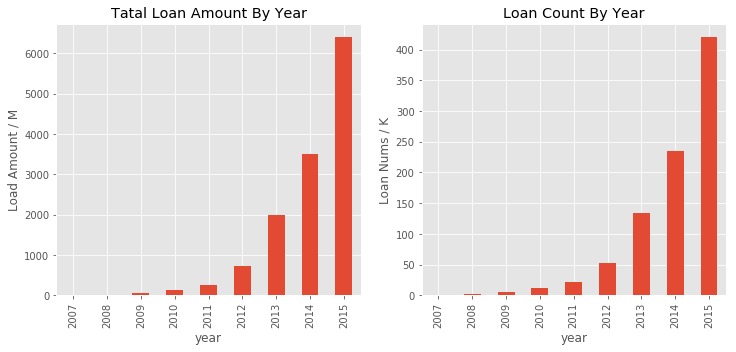

In [14]:
plt.figure(figsize=(12,5))

p2 = plt.subplot(121)
year_loan_stat['sum'].plot(kind='bar')
p2.set_ylabel('Load Amount / M')
p2.set_title('Tatal Loan Amount By Year')

p3 = plt.subplot(122)
year_loan_stat['count'].plot(kind='bar')
p3.set_ylabel('Loan Nums / K')
p3.set_title('Loan Count By Year')

按月份统计的贷款量增长如下：

In [15]:
# 将issue_d 的格式从Dec-2011 转换为 2011-12-01 格式
df['complete_date'] = pd.to_datetime(df['issue_d'])
group_dates = df.groupby('complete_date', as_index=False).sum()
group_dates['issue_d'] = [month.to_period('M') for month in group_dates['complete_date']]
group_dates = group_dates.groupby('issue_d', as_index=False).sum()
group_dates['loan_amount'] = group_dates['loan_amount']/1000

In [16]:
df_dates = pd.DataFrame(data=group_dates[['issue_d','loan_amount']])
df_dates = pd.DataFrame(df_dates.groupby('issue_d')['loan_amount'].sum())

Text(0.5, 1.0, 'Loan Amount by Month(2007-2015)')

<Figure size 432x288 with 0 Axes>

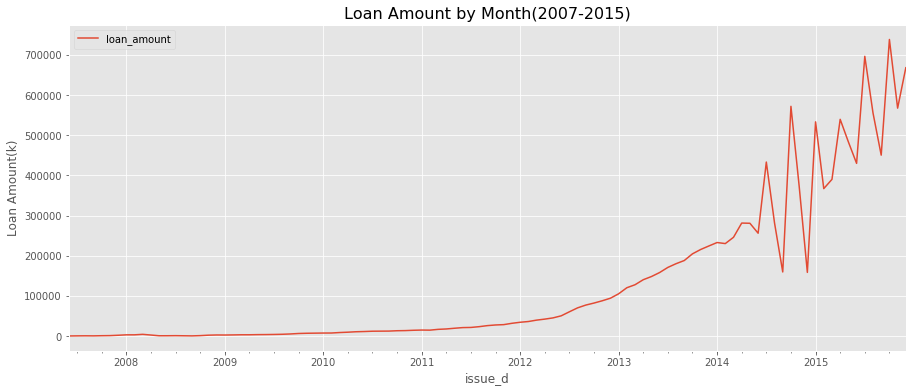

In [17]:
plt.figure()
df_dates.plot(kind='line',grid=True,figsize=(15,6))
plt.ylabel('Loan Amount(k)')
plt.title('Loan Amount by Month(2007-2015)', fontsize=16)

注意到在2014年以前，贷款量的增长曲线非常平滑，在2014年6月之后，新增贷款量出现非常大的波动，大致呈现出**每3个月出现一个贷款量高峰**的模式。

在2014年以后的详图中，从2014年7月起，每隔1个季度，出现一次贷款高峰。
在贷款高峰月，未发现美国利率和资本市场有异常情况，因此可能的解释为：由于某种政策的影响，每个季度开始的月份，是美国消费者债务整合操作的高峰时期。

在实际业务中，如果遇到这样的资金需求量波动周期，应该挖掘出背后的因素，以便提前筹备资金。

Text(0.5, 1.0, 'Loan Amount by Month(2014-2015)')

<Figure size 432x288 with 0 Axes>

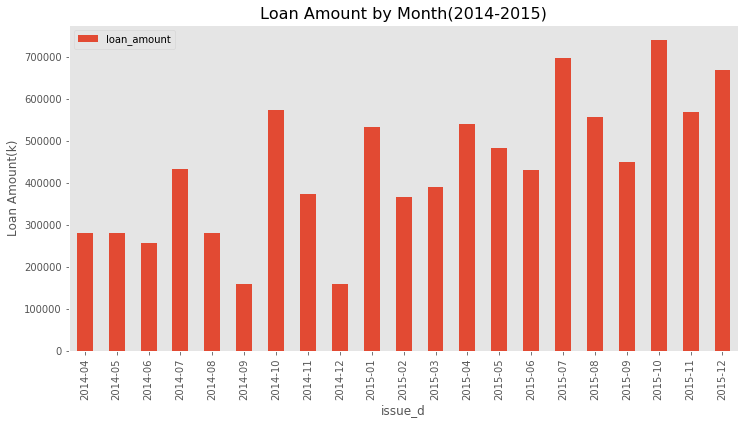

In [18]:
# 显示2014.04之后的局部
plt.figure()
df_dates[df_dates.index >= '2014-04'].plot(kind='bar',grid=False,figsize=(12,6))
plt.ylabel('Loan Amount(k)')
plt.title('Loan Amount by Month(2014-2015)', fontsize=16)

## 2.2 单笔贷款额度分布

采用sns.distplot绘制分布图，注意到：

- 最小的单笔额度为500美元
- 最大额度在2007-2010年为25000美元，在2011年之后，最大额度调整为35000美元
- 在整数额度（5k、10k等），借贷笔数出现高峰，体现出借款用户金额**凑整**的心态
- 贷款额度主要分布在5000-20000美元的区间

Text(0.5, 1.0, 'Loan Amount(2011)')

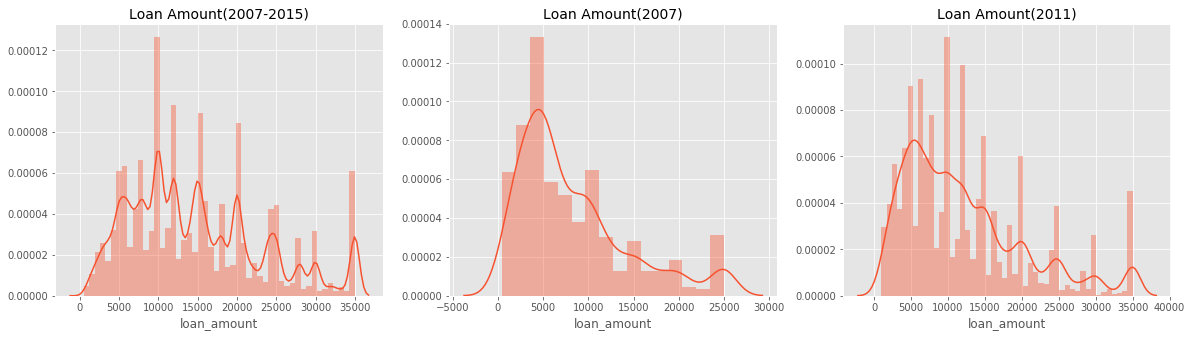

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

sns.distplot(df["loan_amount"], ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Amount(2007-2015)", fontsize=14)

sns.distplot(df[df['year']==2007]["loan_amount"], ax=ax[1], color="#F7522F")
ax[1].set_title("Loan Amount(2007)", fontsize=14)

sns.distplot(df[df['year']==2011]["loan_amount"], ax=ax[2], color="#F7522F")
ax[2].set_title("Loan Amount(2011)", fontsize=14)

## 2.3 各年度贷款额度分析

可以看出，从2007到2015：

- 平均单笔贷款的额度从8254美元增加到15240美元，单笔额度逐年增加；
- 与此同时，用户的年均收入从大约6.5W美元增加到7.7W美元；

用户平均贷款额度与年收入均值的增长，显示了借款人和投资人的信心均随着金融危机后美国经济复苏而增强。
从LC的用户数据来看，金融危机对年收入水平的影响并不大。

In [20]:
# 统计各年度贷款的金额和笔数
year_loan_stat = df.groupby('year')['loan_amount'].agg([sum, 'mean', 'count'], axis='column')
year_loan_stat['sum'] = year_loan_stat['sum'] / 1e6
year_loan_stat['count'] = year_loan_stat['count'] / 1e3

Text(0.5, 1.0, 'Avarage Income of Borrower')

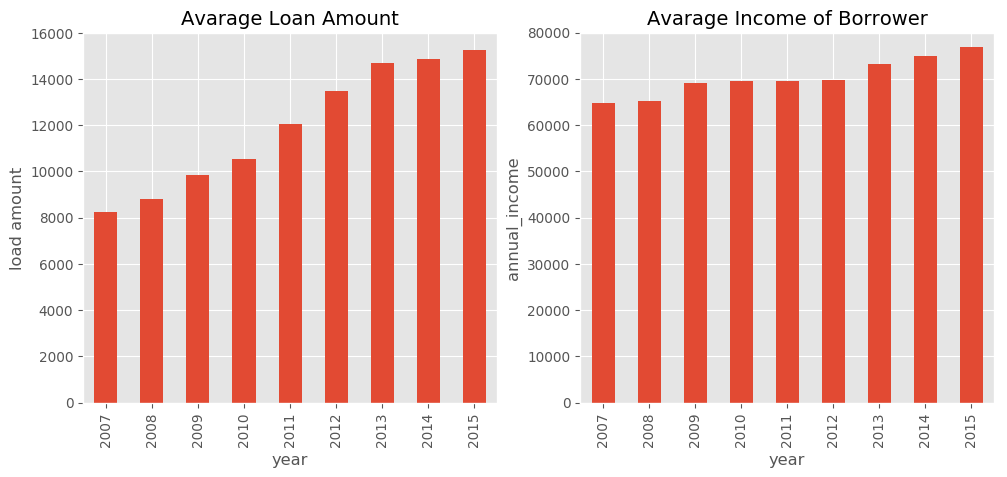

In [21]:
plt.figure(figsize=(12,5),dpi=98)
p1 = plt.subplot(121)
year_loan_stat['mean'].plot(kind='bar')
p1.set_ylabel('load amount')
p1.set_title('Avarage Loan Amount')

p2 = plt.subplot(122)
df.groupby('year')['annual_income'].agg('mean').plot(kind='bar')
p2.set_ylim([0, 80000])
p2.set_ylabel('annual_income')
p2.set_title('Avarage Income of Borrower')

## 2.4 利率与分期

LC的贷款分期数只有**2个档次**：3年分期（36月）、5年分期（60月）。贷款的利率主要由grade评级、贷款额度、分期数决定。对同一个人，申请同一额度，如果分期数增加，贷款评级会下调，即利率增大。

所有贷款项目，最低利率5.32%，最高利率28.99%，平均值在**13.25%**.

In [22]:
def get_term_num(term):
    return int(re.findall(r'(\d\d)', term)[0])
df['term_num'] = df['term'].apply(get_term_num)

(0, 0.18)

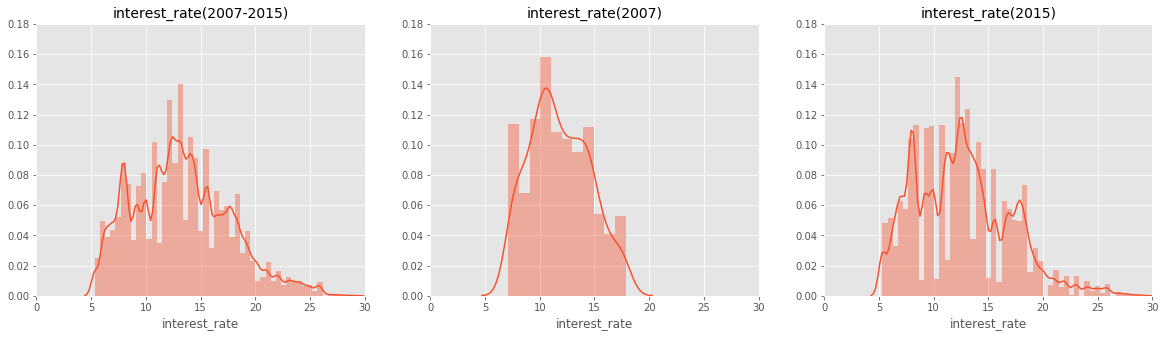

In [23]:
# 从2007到2015年的利率分析
fig, ax = plt.subplots(1, 3, figsize=(20,5))

sns.distplot(df["interest_rate"], ax=ax[0], color="#F7522F")
ax[0].set_title("interest_rate(2007-2015)", fontsize=14)
ax[0].set_xlim([0, 30])
ax[0].set_ylim([0, 0.18])

sns.distplot(df[df['year']==2007]["interest_rate"], ax=ax[1], color="#F7522F")
ax[1].set_title("interest_rate(2007)", fontsize=14)
ax[1].set_xlim([0, 30])
ax[1].set_ylim([0, 0.18])

sns.distplot(df[df['year']==2015]["interest_rate"], ax=ax[2], color="#F7522F")
ax[2].set_title("interest_rate(2015)", fontsize=14)
ax[2].set_xlim([0, 30])
ax[2].set_ylim([0, 0.18])

可以看出：

- 贷款项目的利率主要分布在10%到20%的区间；
- 2007年的项目最高利率不超过18%，到2015年利率的上限达到了29%；
- 与国内的个人贷款项目相比，利息是偏高的如，如
    - 借呗日利息万2.5到万5（年化9.1%-18.25），
    - 微信微粒贷年化18.25%

贷款平均**利率在不同年份有显著变化**。是否与美国基准利率相关呢？

In [24]:
df_year_inte = pd.DataFrame(df.groupby(['year'])['interest_rate'].agg(['mean']))

Text(0.5, 1.0, 'Avarage Interest Rate(2007-2015)')

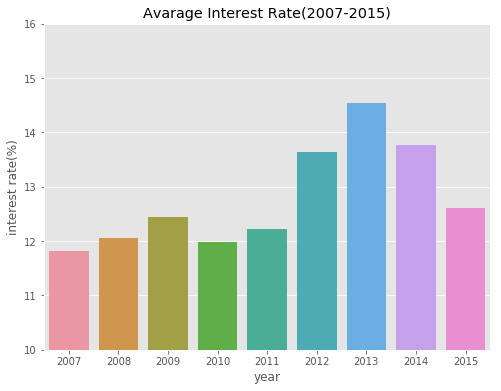

In [25]:
plt.figure(figsize=(8,6))
sns.barplot(df_year_inte.index, df_year_inte['mean'])
plt.ylim([10,16])
plt.ylabel('interest rate(%)')
plt.title('Avarage Interest Rate(2007-2015)')

对比不同**分期数**的利率设置：

- 不同分期，利率的上下限没有显著变化
- 分36期的贷款利率均12.02%，显著小于分60期的利率均值16.11%

In [26]:
df.groupby('term_num')['interest_rate'].agg(['mean', min, max, 'count'])

,mean,min,max,count
term_num,,,,
36,12.02,5.32,28.99,621125
60,16.11,5.79,28.99,266254


对比不同评级分组的贷款利率，评级主要根据FICO信用分，将贷款项目分为A-G的等级，信用依次降低，利率依次增大。

几乎90%的贷款的等级都在A-D，E-G的贷款占总数的比例大约10%。

In [27]:
df_inte_grade = df.groupby('grade')['interest_rate'].agg(['mean', min, max, 'count'])
df_inte_grade['count_ratio(%)'] = df_inte_grade['count'] / df.shape[0] * 100
df_inte_grade

,mean,min,max,count,count_ratio(%)
grade,,,,,
A,7.24,5.32,9.63,148202,16.70
B,10.83,6.00,14.09,254535,28.68
C,13.98,6.00,17.27,245860,27.71
D,17.18,6.00,20.31,139542,15.73
E,19.90,6.00,23.40,70705,7.97
F,23.58,6.00,26.06,23046,2.60
G,25.63,16.59,28.99,5489,0.62


In [28]:
# 分期数和信用等级的综合透视
# df.groupby(['term_num', 'grade'])['interest_rate'].agg(['mean', min, max, 'count'])

## 2.5 贷款用途分析

申请贷款必须填写贷款的用途，最常见的用途是

- **集合债务**贷款
- 偿还高利息的**信用卡**贷款。
- 其余的用途有： 房屋装修、婚礼、汽车、小生意、教育培训。

可以看出集合债务和信用卡是贷款的主要用途，其余的选项占比很少。

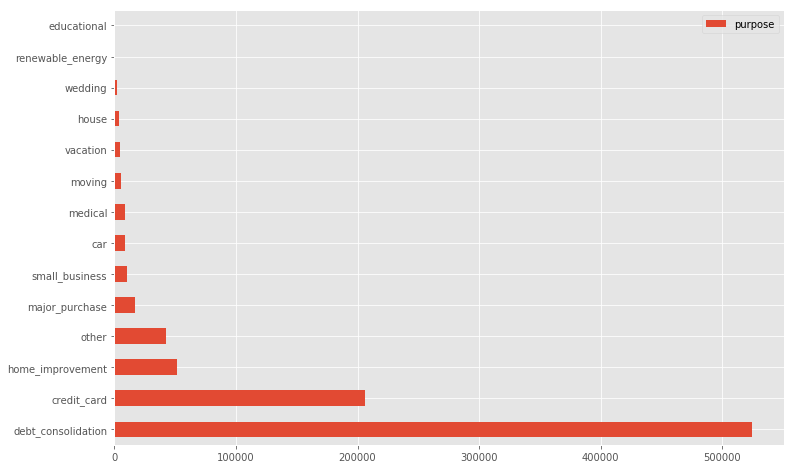

In [29]:
pd.DataFrame(df['purpose'].value_counts()).plot(kind='barh',figsize=(12,8))

## 2.6 用户行为分析

尝试分析LC贷款用户的重复贷款行为，检查数据集中的member_id，发现没有重复的。

In [30]:
print('num of member_id: {}'.format(len(set(df['member_id']))))
print('num of id: {}'.format(len(set(df['id']))))

num of member_id: 887379
num of id: 887379


这意味着所有的用户在2007-2015年，在LC平台上只有一次贷款。这一结论不符合预期，在《Lending Club简史》中，存在一些用户长期在LC上融资。猜测数据可能存在的问题是：

- LC放出公开数据时，只保留了一个用户ID的一次贷款行为；
- 处于隐私保护的考虑，修改了同一个用户在不同贷款项目的member_id;

从贷款额度和分期的角度来看，LC平台的贷款度平均在1万美元以上，分期至少36期。

尤其在分期上缺乏弹性，可以推测贷款用户只有融资需求较大时，才会在LC平台贷款。因此用户行为总体是：**大额、低频**。这种模式可能造成老用户的活跃度不高。

业务特点分析：

- 单笔贷款额度大，最少500美元，最大35000美元
- 周期长，36-60期
- 用户复用率低
- 准入门槛高

并非一个典型的普惠金融案例。
猜想不良贷款率高的主要原因是，在很长的还款周期内，还款的不确定性增大。
借款人在60期还款中，只要有一次逾期，即会被视为不良。

贷款的目的可以理解为做一件大事，而非生活中常规的融资渠道。

# 3. 贷款违约分析

对于各种贷款状态，划分为：

- Bad，不良/坏账
- Late，逾期
- Good，完成还款
- Cur，贷中

| 贷款状态 | 语义 | Bad | Late| Good | Cur |
| ------ |------ | ---- | ---- |---- | ---- |
| Current | 贷中 | - | -| - | Y |
| Fully Paid | 全额还款 | - | -| Y | -|
| **Default** | 违约 | Y | - | - | -|
| **Charged Off** | 坏账 | Y | - |  - | -|
| Issued  | 发布 | - | - |  - | Y |
| In Grace Period | 宽限期（逾期15天之内） | - | Y | - | -|
| Late (16-30 days) | 逾期16-30天 | - | Y| - | -|
| Late (31-120 days) | 逾期31-120天 | _ | Y | - | -|
| Does not meet the credit policy. Status:Fully Paid | 全额还款（不符合信用） | - | -|  Y | -|
| Does not meet the credit policy. Status:Charged Off | 坏账（不符合信用） | Y | - | - | -|



## 3.1 贷款风险与年份


In [31]:
df["loan_status"].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

贷款的状态如上所示，current表示正常进行中，尚未完结，无法确定贷款是否会发展成bad。

因此，排除current状态之后，再计算贷款不良率。

In [32]:
def loan_condition(status):
    if status in ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off"]:
        return 'Bad'
    elif status in ["In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]:
        return 'Late'
    elif status in ['Current','Issued']:
        return 'Cur'
    else: # ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
        return 'Good'

In [33]:
df['loan_condition'] = df['loan_status'].apply(loan_condition)
df['Bad'] = df['loan_condition'] == 'Bad'
df['Late'] = df['loan_condition'] == 'Late'
df['Good'] = df['loan_condition'] == 'Good'
df['Cur'] = df['loan_condition'] == 'Cur'

In [34]:
bad_loan_ratio = (df['Bad'].sum()) / (df.loan_condition.count() - df.Cur.sum())
bad_late_loan_ratio = (df['Bad'].sum() + df['Late'].sum()) /  (df.loan_condition.count() - df.Cur.sum())

In [35]:
print('坏账+逾期贷款比例: {:.3f}'.format(bad_late_loan_ratio))
print('坏账贷款比例: {:.3f}'.format(bad_loan_ratio))
print('逾期贷款比例: {:.3f}'.format(bad_late_loan_ratio - bad_loan_ratio))

坏账+逾期贷款比例: 0.243
坏账贷款比例: 0.170
逾期贷款比例: 0.073


In [36]:
df_good_bad = df.groupby('year')['Good', 'Bad', 'Late', 'Cur', 'loan_amount', 'total_pymnt', 'total_rec_prncp'].sum()

In [37]:
df_good_bad['bad_ratio'] = df_good_bad.Bad/ (df_good_bad.Good + df_good_bad.Bad +  df_good_bad.Late)
df_good_bad['bad_late_ratio'] = (df_good_bad.Bad + df_good_bad.Late)/ (df_good_bad.Good + df_good_bad.Bad +  df_good_bad.Late)
df_good_bad['cur_ratio'] = df_good_bad.Cur / (df_good_bad.Good + df_good_bad.Bad +  df_good_bad.Late + df_good_bad.Cur)
df_good_bad['ratio_pymnt'] = df_good_bad.total_pymnt / df_good_bad.loan_amount
df_good_bad['ratio_prncp'] = df_good_bad.total_rec_prncp / df_good_bad.loan_amount

In [38]:
df_good_bad.head(2)

,Good,Bad,Late,Cur,loan_amount,total_pymnt,total_rec_prncp,bad_ratio,bad_late_ratio,cur_ratio,ratio_pymnt,ratio_prncp
year,,,,,,,,,,,,
2007,445.0,158.0,0.0,0.0,4.98e+06,4.72e+06,3.89e+06,0.26,0.26,0.0,0.95,0.78
2008,1897.0,496.0,0.0,0.0,2.11e+07,2.03e+07,1.69e+07,0.21,0.21,0.0,0.96,0.80


各年度贷款统计如下：

- bad_ratio，除去贷中之后的坏账比例
- cur_ratio，贷中的比例
- ratio_pymnt，总还款额率=（本金+利息）/总贷款额
- ratio_prncp，本金偿还率= 偿还本金/总贷款额

In [39]:
df_good_bad[['bad_ratio', 'cur_ratio', 'ratio_pymnt', 'ratio_prncp']]

,bad_ratio,cur_ratio,ratio_pymnt,ratio_prncp
year,,,,
2007,0.26,0.00e+00,0.95,0.78
2008,0.21,0.00e+00,0.96,0.80
2009,0.14,0.00e+00,1.08,0.90
2010,0.14,5.58e-04,1.07,0.87
2011,0.16,8.99e-02,1.08,0.86
2012,0.16,6.45e-02,1.08,0.85
2013,0.20,4.47e-01,0.95,0.73
2014,0.19,6.73e-01,0.64,0.48
2015,0.09,9.17e-01,0.21,0.15


可以看出：

- 2007-2009年的贷款没有Current
    - 2007-2008，贷款不良率超过20%，本金回收率只有0.78和0.80，总体上有资金损失；
    - 2009年，贷款不良率在14%，总体还款/本金比率为1.08，即总体上是有收益的。
- 2010-2012年，current状态的贷款，比例不超过10%
    - 总体还款/本金比率为1.08
    - 贷款不良率稳定在0.14-0.16，本金收回率在0.87 
- 2013-2015年，大量的贷款处于Current，因此回收资金的比例很低。
贷中项目最终可能发展为Bad/Good/Late中的一类，当前的贷款不良率没有反应真实的违约状况。

Text(0, 0.5, 'ratio')

<Figure size 432x288 with 0 Axes>

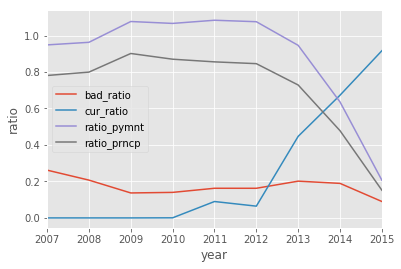

In [40]:
plt.figure()
df_good_bad[['bad_ratio', 'cur_ratio', 'ratio_pymnt', 'ratio_prncp']].plot()
plt.ylabel('ratio')

In [41]:
bad_ratio_prncp = df[df.Bad]['total_pymnt'].sum() /  df[df.Bad]['loan_amount'].sum()
print('Principal Payment ratio of Bad loans: {}'.format(bad_ratio_prncp))

Principal Payment ratio of Bad loans: 0.43704272210749534


In [42]:
df['terms_pynmt'] = df.total_pymnt / df.installment

36 期贷款违约期数均值: 13.90
60 期贷款违约期数均值: 15.50


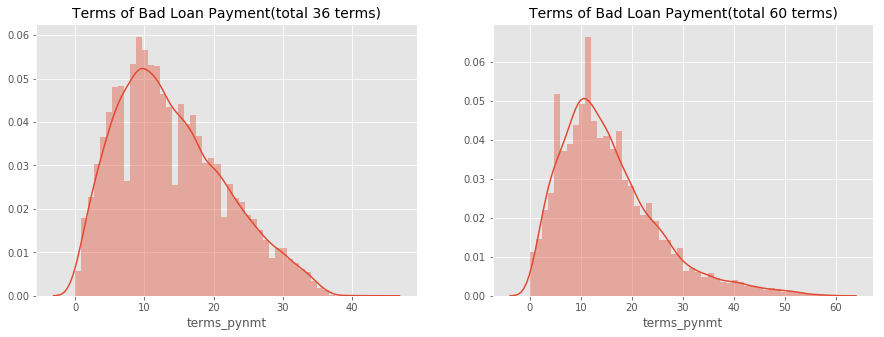

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(df[df.Bad & (df.term_num == 36)].terms_pynmt, ax=ax[0])
ax[0].set_title("Terms of Bad Loan Payment(total 36 terms)", fontsize=14)
tmp = df[df.Bad & (df.term_num == 36)].terms_pynmt.mean()
print('36 期贷款违约期数均值: {:0.2f}'.format(tmp))

sns.distplot(df[df.Bad & (df.term_num == 60)].terms_pynmt, ax=ax[1])
ax[1].set_title("Terms of Bad Loan Payment(total 60 terms)", fontsize=14)
tmp = df[df.Bad & (df.term_num == 60)].terms_pynmt.mean()
print('60 期贷款违约期数均值: {:0.2f}'.format(tmp))

## 3.2 贷款风险与信用等级

### 贷款评级分析

LC贷款数据中，贷款评级grade直接体现了信用等级。不同等级的贷款不良率如下：

In [44]:
loan_by_grade = df.groupby(['grade', 'loan_condition']).size().unstack()
loan_by_grade['bad_late_ratio'] = (loan_by_grade['Bad'] + loan_by_grade['Late']) / (loan_by_grade['Bad'] + loan_by_grade['Good'] + loan_by_grade['Late']) * 100

amount_by_grade = pd.DataFrame(df.groupby('grade')['loan_amount'].sum())
amount_by_grade['amount_ratio'] = amount_by_grade['loan_amount']/amount_by_grade['loan_amount'].sum()*100

Text(0.5, 1.0, 'Bad Late Loan Ratio by Grade')

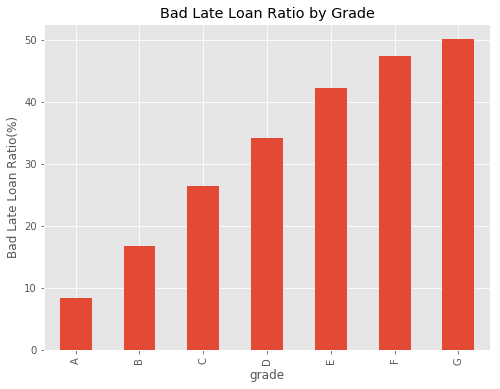

In [45]:
plt.figure(figsize=(8,6))
p1 = plt.subplot(111)
loan_by_grade.bad_late_ratio.plot(kind='bar')
p1.set_ylabel('Bad Late Loan Ratio(%)')
p1.set_title('Bad Late Loan Ratio by Grade')

Text(0.5, 1.0, 'Loan Amount Ratio by Grade')

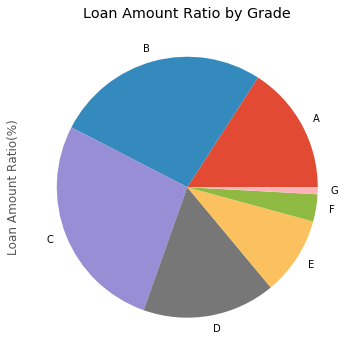

In [46]:
plt.figure(figsize=(6,6))
p2 = plt.subplot(111)
amount_by_grade['amount_ratio'].plot(kind='pie') # 此处应为饼图
p2.set_ylabel('Loan Amount Ratio(%)')
p2.set_title('Loan Amount Ratio by Grade')

随着grade降级贷款的不良率单调增加，这说明了美国的FICO信用评价是非常可靠的。E-G级别贷款的不良率很高，但从贷款总量上来看，占比并不大。因此要控制总体的贷款不良率，主要还是应该从B、C级别的贷款入手。

对grade的下的细分等级统计不良率：

Text(0.5, 1.0, 'Bad Loan Ratio by Grade')

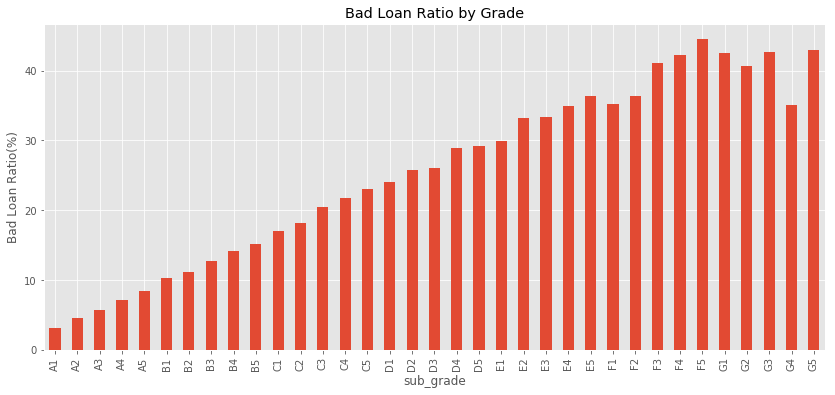

In [47]:
# 按subgrade 分类
loan_by_subgrade = df.groupby(['sub_grade', 'loan_condition']).size().unstack()
loan_by_subgrade['bad_ratio'] = loan_by_subgrade['Bad'] / (loan_by_subgrade['Bad'] + loan_by_subgrade['Good']) *100

plt.figure()
loan_by_subgrade.bad_ratio.plot(kind='bar',figsize=(14,6), grid=True)
plt.ylabel('Bad Loan Ratio(%)')
plt.title('Bad Loan Ratio by Grade')

### 收入水平分析

对借款人的**收入水平分级**：

- 年收入<10w美元：low
- 年收入在10w和20w美元之间：medium
- 年收入大于20w美元：high

In [48]:
# Let's create categories for annual_income since most of the bad loans are located below 100k

df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

In [49]:
loan_by_income_level = df.groupby(['income_category', 'loan_condition']).size().unstack()
loan_by_income_level['bad_ratio'] = loan_by_income_level['Bad'] / (loan_by_income_level['Bad'] + loan_by_income_level['Good']) * 100
loan_by_income_level.sort_values('bad_ratio', ascending=False, inplace=True)

Text(0.5, 1.0, 'Loan Amount Distribution by Income Level')

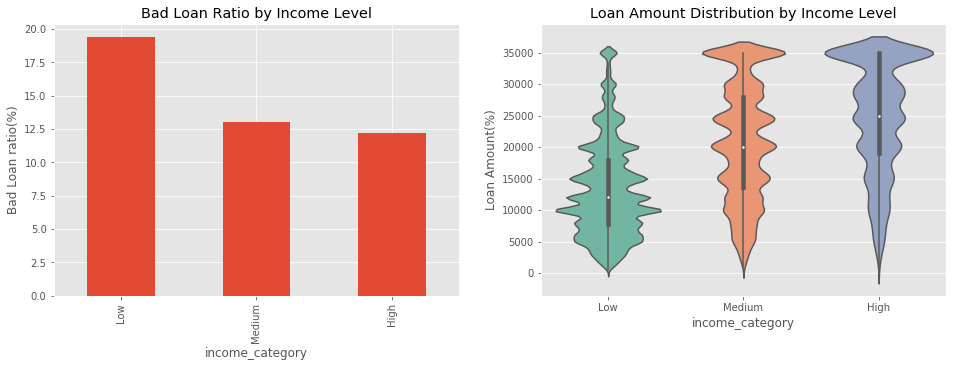

In [50]:
plt.figure(figsize=(16,5))
p1 = plt.subplot(121)
loan_by_income_level.bad_ratio.plot(kind='bar')
p1.set_ylabel('Bad Loan ratio(%)')
p1.set_title('Bad Loan Ratio by Income Level')

p2 = plt.subplot(122)
sns.violinplot(x="income_category", y="loan_amount", data=df, palette="Set2")
p2.set_ylabel('Loan Amount(%)')
p2.set_title('Loan Amount Distribution by Income Level')

可以看出：

- 在统计意义上，高收入群体的贷款不良率更低；
- 从贷款数额上看，高收入群体的贷款额度也更大；

在LC的用户群中，高收入群体可以作为优质用户。

需要注意的是，高收入并不等价于高信用，依然存在E-G低信用评级的贷款。

Text(0.5, 1.0, 'High Income Borrower Loan Grade')

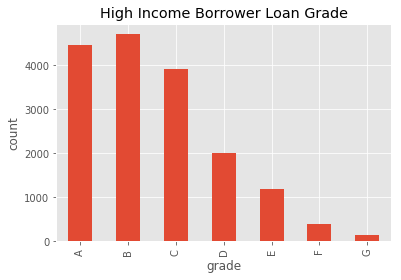

In [51]:
grade_by_income = df.groupby([ 'grade','income_category']).size().unstack()
plt.figure()
grade_by_income['High'].plot(kind='bar')
plt.ylabel('count')
plt.title('High Income Borrower Loan Grade')

## 3.3 贷款风险与分期数

LC的贷款分期数只有36月和60月分期两种，分析两种分期模式下贷款的不良率：

In [52]:
loan_by_term = df.groupby(['term','loan_condition']).size().unstack()
loan_by_term['bad_ratio'] = loan_by_term['Bad'] / (loan_by_term['Bad'] + loan_by_term['Good']) * 100
loan_by_term

loan_condition,Bad,Cur,Good,Late,bad_ratio
term,,,,,
36 months,30447,408830,169364,12484,15.24
60 months,16781,201409,40347,7717,29.37


Text(0.5, 1.0, 'Bad Loan Ratio by Grade')

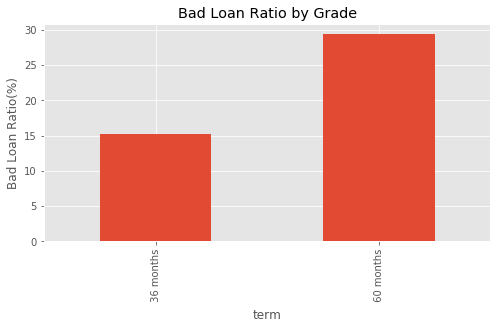

In [53]:
plt.figure()
loan_by_term.bad_ratio.plot(kind='bar',figsize=(8,4), grid=True)
plt.ylabel('Bad Loan Ratio(%)')
plt.title('Bad Loan Ratio by Grade')

从统计上来看，60月分期的贷款不良率显著高于36月分期的贷款。综合分期数和贷款等级，如下：

Text(0.5, 1.0, 'Loan Grade by Term')

<Figure size 432x288 with 0 Axes>

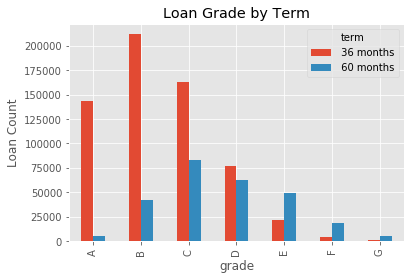

In [54]:
grade_by_term = df.groupby(['grade','term']).size().unstack()

plt.figure()
grade_by_term.plot(kind='bar')
plt.ylabel('Loan Count')
plt.title('Loan Grade by Term')

注意到：

- A-D评级较高的贷款中，分期36的数量多于分期60
- E-G评级较低的贷款中，分期60月的贷款比例很高

即由于更多的高风险贷款选择了60月分期，使得60月分期贷款的总体不良率更高。对比各等级贷款，在不同分期数下的不良率，注意到各等级的贷款，采用60月分期的贷款总体比36月分期的不良率更低。

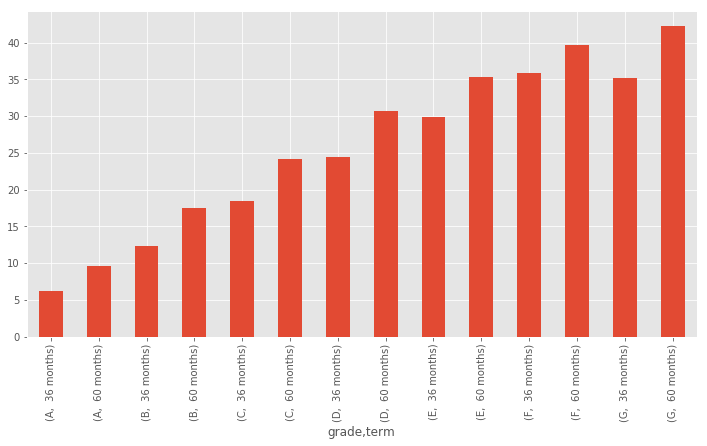

In [55]:
loan_by_term_grade = df.groupby(['grade','term','loan_condition']).size().unstack()
loan_by_term_grade['bad_ratio'] = loan_by_term_grade['Bad'] / (loan_by_term_grade['Bad'] + loan_by_term_grade['Good']) * 100
loan_by_term_grade.bad_ratio.plot(kind='bar',figsize=(12,6), grid=True)

## 3.4 贷款用途与使用目的

最常见的用途是**集合债务**贷款，或者偿还高利息的**信用卡**贷款。

其余的用途有： 房屋装修、婚礼、汽车、小生意、教育培训。

不同目的贷款的不良率如：

In [56]:
loan_by_purpose = df.groupby(['purpose', 'loan_condition']).size().unstack()
loan_by_purpose['bad_ratio'] = loan_by_purpose['Bad'] / (loan_by_purpose['Bad'] + loan_by_purpose['Good']) * 100
loan_by_purpose.sort_values('bad_ratio', ascending=True, inplace=True)

Text(0.5, 1.0, 'Bad Loan Ratio by Purpose')

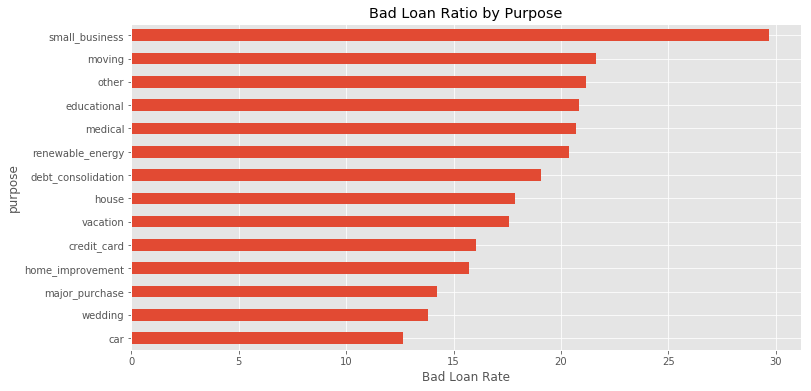

In [57]:
plt.figure()
loan_by_purpose.bad_ratio.plot(kind='barh',figsize=(12,6), grid=True)
plt.xlabel('Bad Loan Rate')
plt.title('Bad Loan Ratio by Purpose')

注意到：

- 贷款不良率最高的类别是教育（20.8%）和小生意（17.16%）
- 集合债务、信用卡是贷款量最大的业务，不良率相对较低，即**主营业务**风险可控性强

为何用于教育培训的贷款不良率是最高的呢？教育类贷款总共423笔，其中88笔不良，发放年份集中在2007-2010年，2010年之后几乎没有再发放教育类贷款。可能的原因分析：

- 2007-2010年是金融危机之后就业形势总体较差的时期，在这一阶段贷款用于教育，很可能投入的资金难以取得回报
- 可能由于教育类贷款总体风险太高，LC在2010年之后，基本停止了教育类贷款的发放

## 3.5 其他因素的分析

对其他因素的分析没有发现与贷款不良率有较强的相关性。

- 贷款额度
- 贷款人住址地域
此处的地域分类为美国各州的东南、东北等大区域

可以看出，贷款额度、贷款人地域等因素对贷款不良率几乎没有影响。

Text(0.5, 1.0, 'Aavage Loan Amount by grade')

<Figure size 432x288 with 0 Axes>

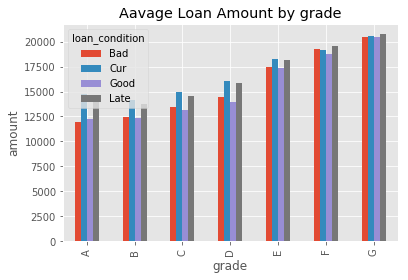

In [58]:
# 与贷款额度的关系
amount_by_grade_cond = df.groupby(['grade','loan_condition'])['loan_amount'].mean().unstack()
plt.figure()
amount_by_grade_cond.plot(kind='bar')
plt.ylabel('amount')
plt.title('Aavage Loan Amount by grade')

In [59]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

df['region'] = df['addr_state'].apply(finding_regions)

In [60]:
loan_by_region = df.groupby(['region', 'loan_condition']).size().unstack()
loan_by_region['bad_ratio'] = loan_by_region['Bad'] / (loan_by_region['Bad'] + loan_by_region['Good']) * 100
loan_by_region

loan_condition,Bad,Cur,Good,Late,bad_ratio
region,,,,,
MidWest,7678,111249,33002,3100,18.87
NorthEast,11124,140519,47747,5009,18.90
SouthEast,11575,149757,48210,5104,19.36
SouthWest,5019,72828,24339,2388,17.10
West,11832,135886,56413,4600,17.34


Text(0.5, 1.0, 'Bad Loan Ratio by Adrress Region')

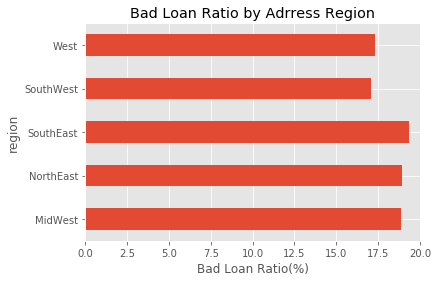

In [61]:
plt.figure()
loan_by_region.bad_ratio.plot(kind='barh')
plt.xlabel('Bad Loan Ratio(%)')
plt.xlim([0,20])
plt.title('Bad Loan Ratio by Adrress Region')

# 4. 各类贷款的收益比

## 不同信用级别

In [62]:
df_non_cur = df[df.Cur == 0]
df_non_cur = df_non_cur[df_non_cur.year.map(lambda y: y in list(range(2007,2013)))]

In [63]:
pymnt_by_grade = df_non_cur.groupby('grade')['total_pymnt','total_rec_prncp','loan_amount'].sum()

In [64]:
pymnt_by_grade['ratio_pymnt'] = pymnt_by_grade.total_pymnt / pymnt_by_grade.loan_amount
pymnt_by_grade['ratio_prncp'] = pymnt_by_grade.total_rec_prncp / pymnt_by_grade.loan_amount

In [65]:
pymnt_by_grade

,total_pymnt,total_rec_prncp,loan_amount,ratio_pymnt,ratio_prncp
grade,,,,,
A,2.19e+08,1.98e+08,2.07e+08,1.06,0.95
B,3.60e+08,3.03e+08,3.32e+08,1.08,0.91
C,2.45e+08,1.97e+08,2.26e+08,1.08,0.87
D,1.79e+08,1.36e+08,1.65e+08,1.08,0.83
E,1.04e+08,7.31e+07,9.84e+07,1.06,0.74
F,4.57e+07,3.01e+07,4.43e+07,1.03,0.68
G,1.39e+07,9.03e+06,1.33e+07,1.04,0.68


观点：F G等级的贷款风险大，且最终的收益率低，**停止发放F/G等级的贷款**。

Text(0.5, 1.0, 'Payment Ratio by Loan Grades')

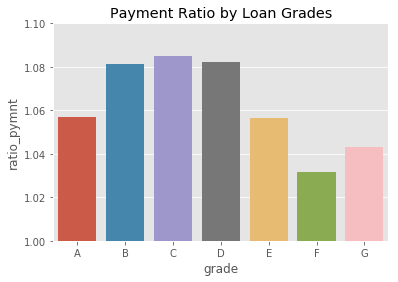

In [66]:
plt.figure()
sns.barplot(x=pymnt_by_grade.index, y='ratio_pymnt',data=pymnt_by_grade)
plt.ylim([1.0,1.10])
plt.title('Payment Ratio by Loan Grades')

## 不同收入群体

In [67]:
pymnt_by_income = df_non_cur.groupby('income_category')['total_pymnt','total_rec_prncp','loan_amount'].sum()
pymnt_by_income['ratio_pymnt'] = pymnt_by_income.total_pymnt / pymnt_by_income.loan_amount
pymnt_by_income['ratio_prncp'] = pymnt_by_income.total_rec_prncp / pymnt_by_income.loan_amount

In [68]:
pymnt_by_income

,total_pymnt,total_rec_prncp,loan_amount,ratio_pymnt,ratio_prncp
income_category,,,,,
High,3.04e+07,2.47e+07,2.72e+07,1.12,0.91
Low,9.17e+08,7.45e+08,8.61e+08,1.06,0.86
Medium,2.19e+08,1.78e+08,1.99e+08,1.10,0.89


Text(0.5, 1.0, 'Payment Ratio by Income Level')

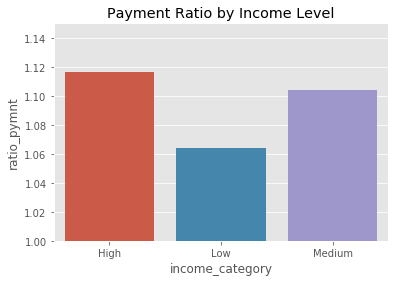

In [69]:
plt.figure()
sns.barplot(x=pymnt_by_income.index, y='ratio_pymnt',data=pymnt_by_income)
plt.ylim([1.0,1.15])
plt.title('Payment Ratio by Income Level')